In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

DATA_DIR = "test_files"  
SEQUENCE_LENGTH = 100  
FEATURES = ['x', 'y', 'velocity', 'angle']  


def preprocess_session(file_path):
    df = pd.read_csv(file_path)
    
    epsilon = 1e-6
    df['x'] = df['x'] / (df['x'].max() + epsilon)
    df['y'] = df['y'] / (df['y'].max() + epsilon)
    
    
    df['velocity'] = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)
    df['velocity'].fillna(0, inplace=True)
    
    
    df['angle'] = np.arctan2(df['y'].diff().fillna(0), df['x'].diff().fillna(0))
    df['angle'].fillna(0, inplace=True)
    
    
    data = df[FEATURES].to_numpy()
    
    
    if len(data) < SEQUENCE_LENGTH:
        pad_width = SEQUENCE_LENGTH - len(data)
        data = np.pad(data, ((0, pad_width), (0, 0)), mode='edge')
    else:
        data = data[:SEQUENCE_LENGTH]
    
    return data


def load_data(data_dir):
    sequences = []
    labels = []
    
    users = os.listdir(data_dir)
    for user in users:
        user_path = os.path.join(data_dir, user)
        if os.path.isdir(user_path):
            for file in os.listdir(user_path):
                if file.endswith(".csv"):  
                    file_path = os.path.join(user_path, file)
                    sequence = preprocess_session(file_path)
                    sequences.append(sequence)
                    labels.append(user)
    
    
    sequences = np.array(sequences)
    labels = np.array(labels)
    
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    return sequences, labels, label_encoder

sequences, labels, label_encoder = load_data(DATA_DIR)

labels_one_hot = to_categorical(labels)

print(f"Sequences shape: {sequences.shape}, Labels shape: {labels.shape}")

Sequences shape: (1611, 100, 4), Labels shape: (1611,)


In [2]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def create_lstm_with_embedding_model(input_shape, num_classes):
    # Embedding Network
    embedding_network = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(128, return_sequences=True),  
        layers.LSTM(128, return_sequences=True),  
        layers.TimeDistributed(layers.Dense(256, activation='relu'))  
    ])
    
    
    inputs = layers.Input(shape=(None, input_shape[-1]))  
    x = embedding_network(inputs)  
    x = layers.LSTM(384, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = layers.Dropout(0.3)(x)  
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(192, kernel_regularizer=l2(0.001))(x)
    x = layers.Dropout(0.3)(x)  
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.Dropout(0.3)(x)  
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model



In [3]:
from tensorflow.keras.callbacks import EarlyStopping

sequences, labels, label_encoder = load_data('training_files')

x_train, x_val, y_train, y_val = train_test_split(sequences, labels, test_size=0.2, random_state=42)

def augment_sequence(sequence):
    noise = np.random.normal(0, 0.01, sequence.shape)
    return sequence + noise

# def augment_sequence(sequence):
#     noise = np.random.normal(0, 0.02, sequence.shape)
#     scale = np.random.uniform(0.8, 1.2)
#     augmented_sequence = sequence * scale + noise
#     return augmented_sequence

augmented_sequences = [augment_sequence(seq) for seq in x_train]
x_train = np.concatenate([x_train, augmented_sequences])
y_train = np.concatenate([y_train, y_train])  

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


input_shape = x_train.shape[1:]  
num_classes = len(label_encoder.classes_)

model = create_lstm_with_embedding_model(input_shape, num_classes)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping,]  
)

Epoch 1/50
4/4 [==============================] - 9s 789ms/step - loss: 3.3365 - accuracy: 0.0385 - val_loss: 3.3476 - val_accuracy: 0.1538
Epoch 2/50
4/4 [==============================] - 1s 295ms/step - loss: 3.2217 - accuracy: 0.2308 - val_loss: 3.3404 - val_accuracy: 0.0769
Epoch 3/50
4/4 [==============================] - 1s 297ms/step - loss: 3.1423 - accuracy: 0.2404 - val_loss: 3.3317 - val_accuracy: 0.0769
Epoch 4/50
4/4 [==============================] - 1s 304ms/step - loss: 3.0949 - accuracy: 0.2788 - val_loss: 3.3240 - val_accuracy: 0.0769
Epoch 5/50
4/4 [==============================] - 1s 302ms/step - loss: 3.0823 - accuracy: 0.2692 - val_loss: 3.3173 - val_accuracy: 0.0769
Epoch 6/50
4/4 [==============================] - 1s 312ms/step - loss: 3.0227 - accuracy: 0.2885 - val_loss: 3.3115 - val_accuracy: 0.1538
Epoch 7/50
4/4 [==============================] - 1s 293ms/step - loss: 2.9507 - accuracy: 0.3654 - val_loss: 3.3060 - val_accuracy: 0.1538
Epoch 8/50
4/4 [====

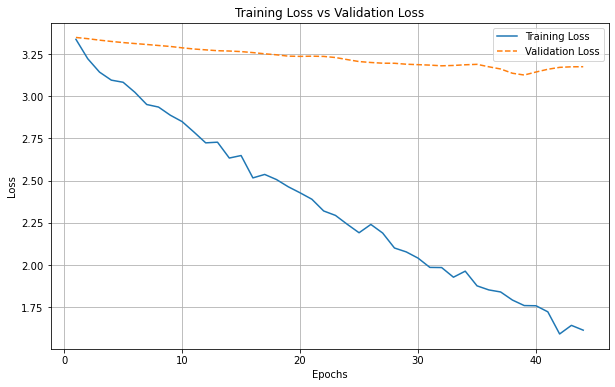

In [4]:
import matplotlib.pyplot as plt


# Extract training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training loss vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def load_test_data(test_dir, label_encoder):
    test_sequences = []
    test_labels = []
    
    users = os.listdir(test_dir)
    for user in users:
        user_path = os.path.join(test_dir, user)
        if os.path.isdir(user_path):
            for file in os.listdir(user_path):
                if file.endswith(".csv"):  
                    file_path = os.path.join(user_path, file)
                    sequence = preprocess_session(file_path)
                    test_sequences.append(sequence)
                    test_labels.append(user)
    
    
    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)
    
    
    test_labels = label_encoder.transform(test_labels)
    
    return test_sequences, test_labels


TEST_DIR = "training_files"  
x_test, y_test = load_test_data(TEST_DIR, label_encoder)

print(f"Test Sequences shape: {x_test.shape}, Test Labels shape: {y_test.shape}")

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Sequences shape: (65, 100, 4), Test Labels shape: (65,)
3/3 [==============================] - 0s 64ms/step - loss: 2.8630 - accuracy: 0.6769
Test Loss: 2.863013744354248, Test Accuracy: 0.6769230961799622
